In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

In [2]:
dfLinAcc = pd.read_csv('Linear Acceleration.csv')

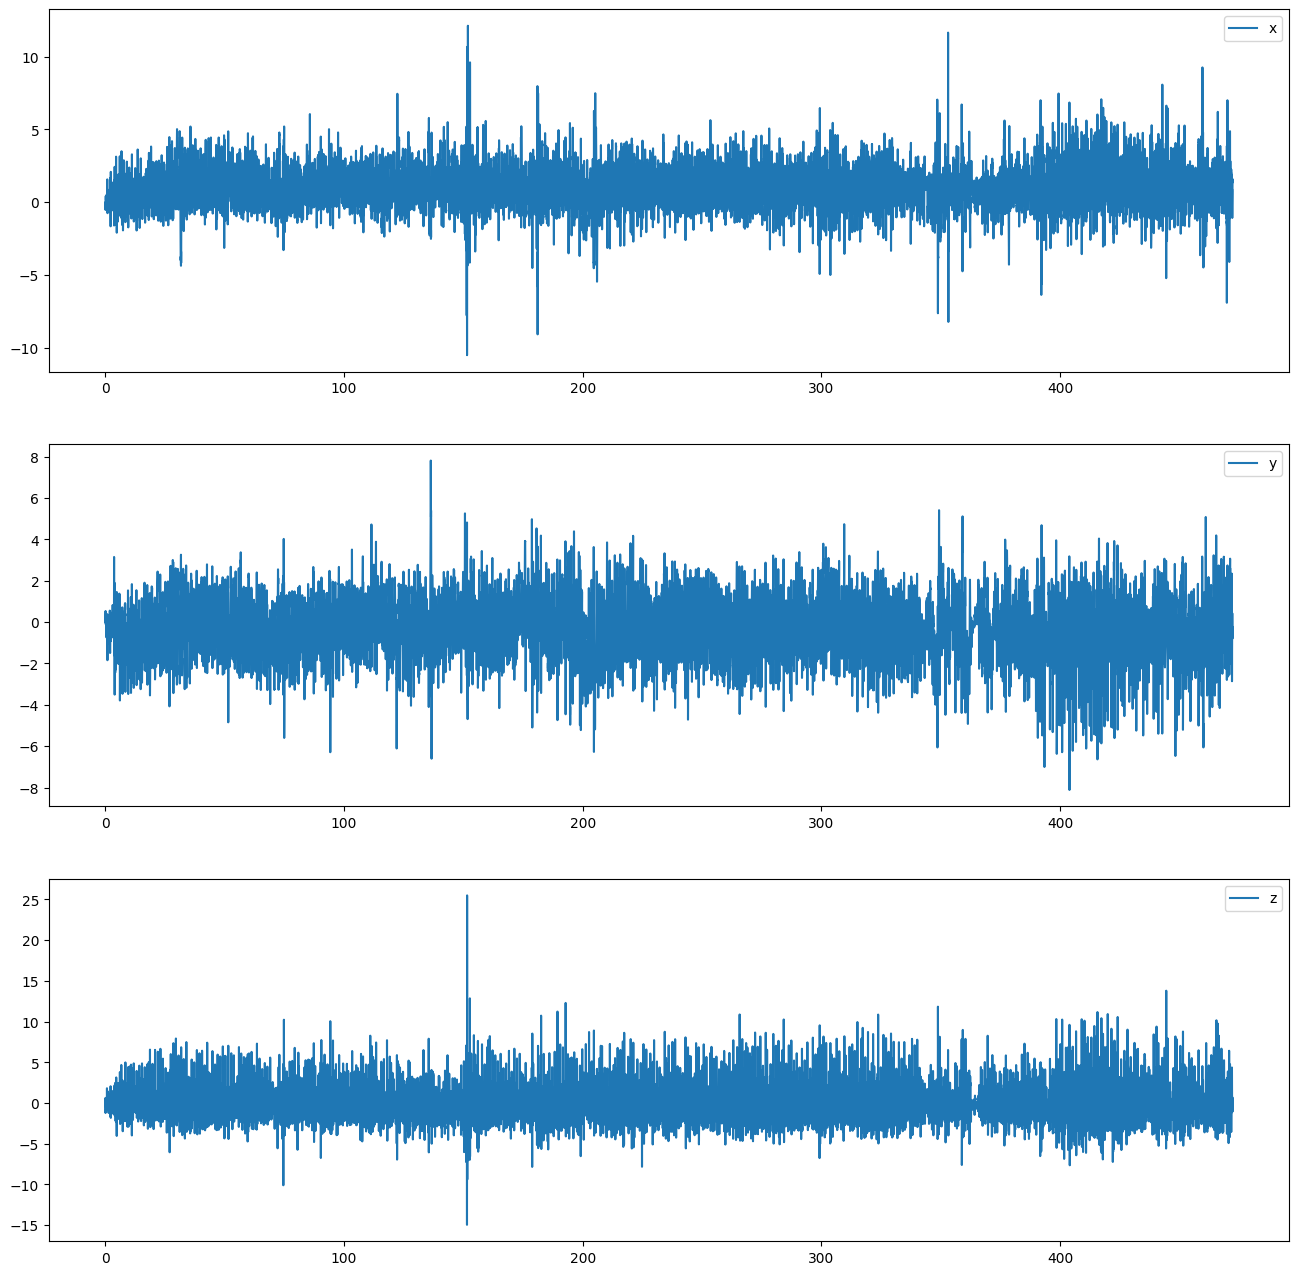

In [3]:
#ASKELMÄÄRÄ LASKETTUNA SUODATETUSTA KIIHTYVYYSDATASTA:
plt.figure(figsize=(16,16))
plt.subplot(3,1,1)
plt.plot(dfLinAcc['Time (s)'], dfLinAcc['Linear Acceleration x (m/s^2)'])
plt.legend(['x'])
plt.subplot(3,1,2)
plt.plot(dfLinAcc['Time (s)'], dfLinAcc['Linear Acceleration y (m/s^2)'])
plt.legend(['y'])
plt.subplot(3,1,3)
plt.plot(dfLinAcc['Time (s)'], dfLinAcc['Linear Acceleration z (m/s^2)'])
plt.legend(['z'])
plt.show()

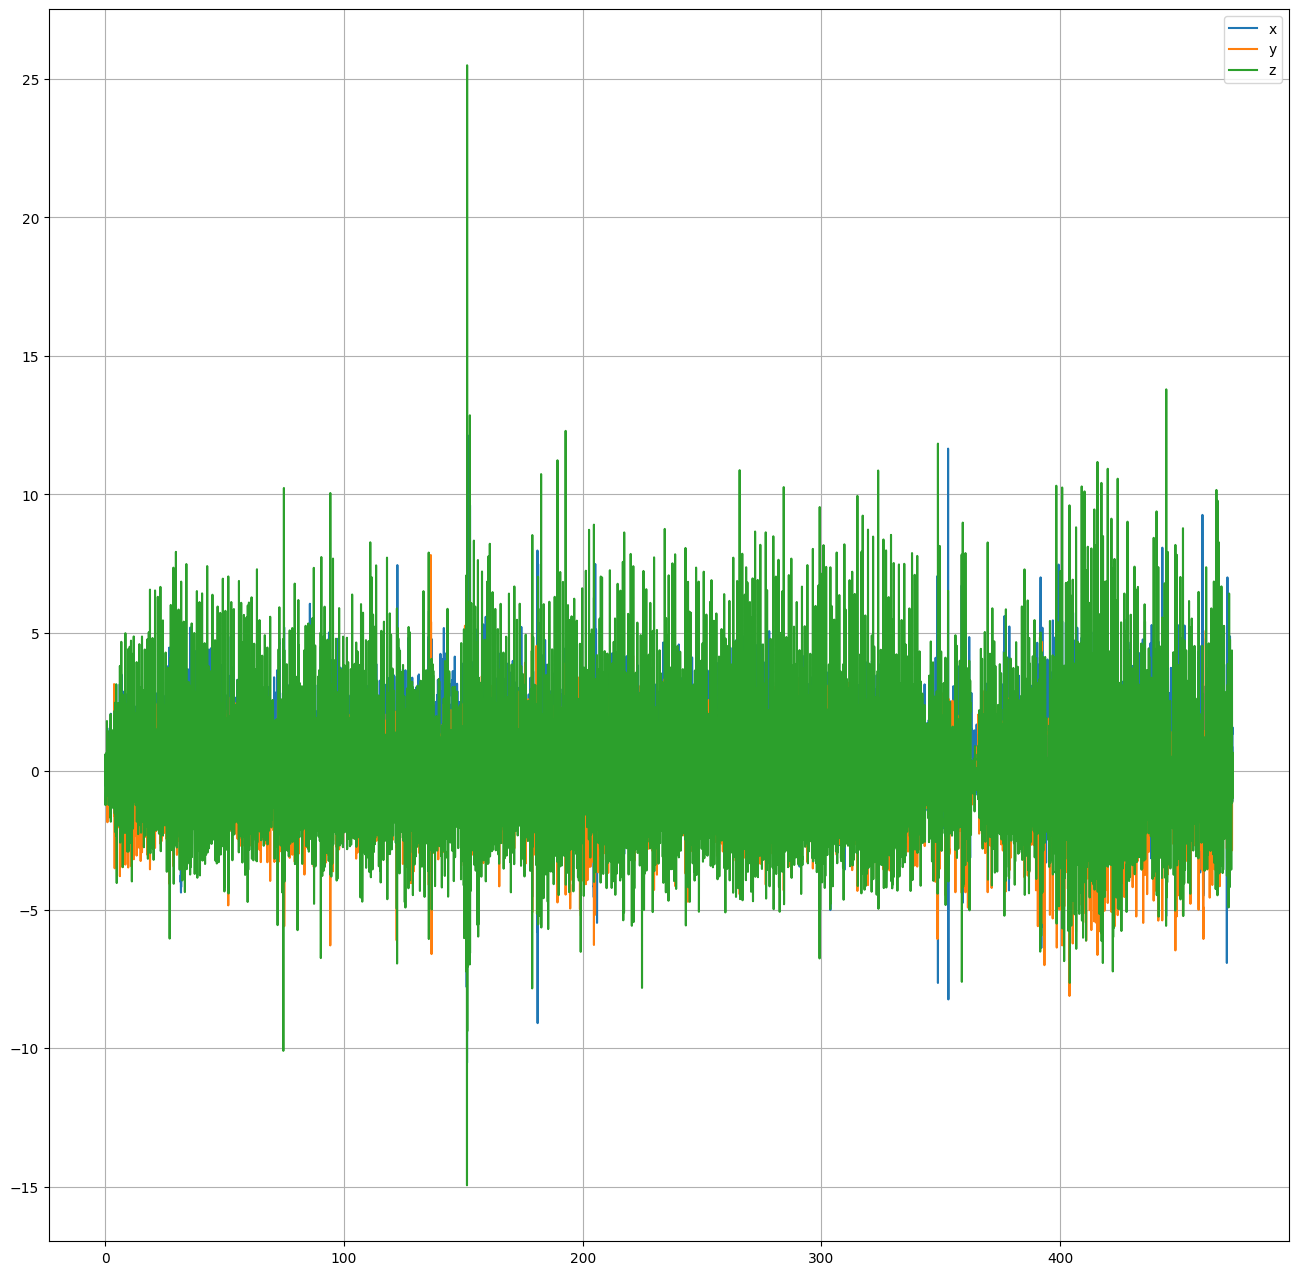

In [4]:
plt.figure(figsize=(16,16))
plt.plot(dfLinAcc['Time (s)'], dfLinAcc['Linear Acceleration x (m/s^2)'])
plt.plot(dfLinAcc['Time (s)'], dfLinAcc['Linear Acceleration y (m/s^2)'])
plt.plot(dfLinAcc['Time (s)'], dfLinAcc['Linear Acceleration z (m/s^2)'])
plt.legend (['x', 'y', 'z'])
plt.grid()
plt.show()


(np.float64(0.0), np.float64(20.0), np.float64(-3.0), np.float64(3.0))

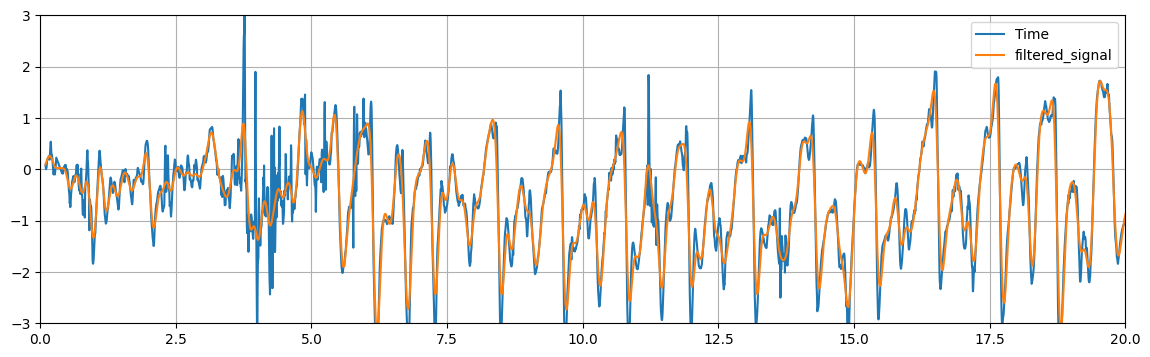

In [5]:
df_steps = dfLinAcc['Linear Acceleration y (m/s^2)']

#Suodatetaan datasta selvästi kävelytaajuutta suurempitaajuuksiset vaihtelut pois
#Filtteri:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    #Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

#Filttereiden parametrit:
T = dfLinAcc['Time (s)'][len(dfLinAcc['Time (s)']) - 1] - dfLinAcc['Time (s)'][0] #Koko datan pituus
n = len(dfLinAcc['Time (s)']) #Datapisteiden lukumäärä
fs = n/T #Näytteenottotaajuus (olettaen jotakuinkin vakioksi)
nyq = fs/2 #Nyqvistin taajuus
order = 3 #Kertaluku
cutoff = 1/(0.2) #Cut-off taajuus

filtered_signal = butter_lowpass_filter(dfLinAcc['Linear Acceleration y (m/s^2)'], cutoff, nyq, order)

plt.figure(figsize=(14,4))
plt.plot(dfLinAcc['Time (s)'],dfLinAcc['Linear Acceleration y (m/s^2)'] )
plt.plot(dfLinAcc['Time (s)'],filtered_signal)
plt.legend (['Time', 'filtered_signal'])
plt.grid()
plt.axis([0,20,-3,3])

(np.float64(0.0), np.float64(20.0), np.float64(-3.0), np.float64(3.0))

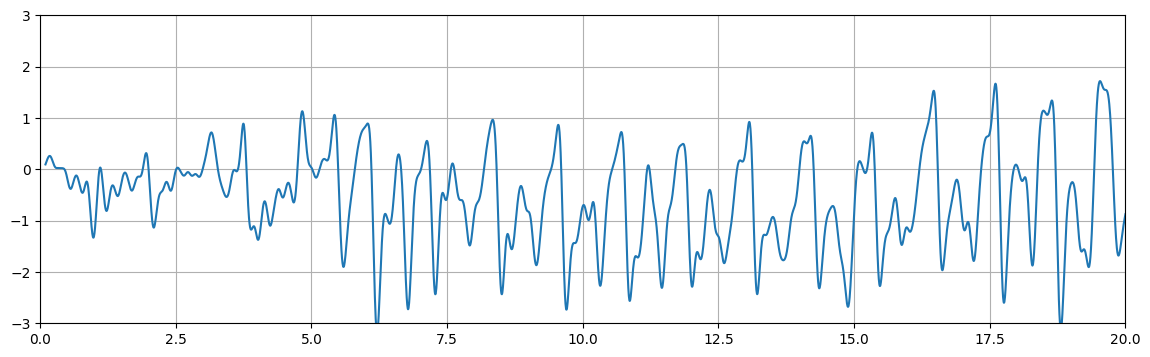

In [83]:
plt.figure(figsize = (14,4))
plt.plot(dfLinAcc['Time (s)'],filtered_signal)
plt.grid()
plt.axis([0,20,-3,3])

In [7]:
#Lasketaan jaksojen määrä signaalissa (ja sitä kautta askelten määrä) laskemalla signaalin nollakohtien ylitysten määrä.
#Nolla ylitetään kaksi kertaa jakson aikana.
jaksot = 0
for i in range(len(filtered_signal)-1):
    if filtered_signal[i]/filtered_signal[i+1] < 0:
        jaksot = jaksot + 1
jaksot

print('Askelmäärä on', np.floor(jaksot / 2))

Askelmäärä on 726.0


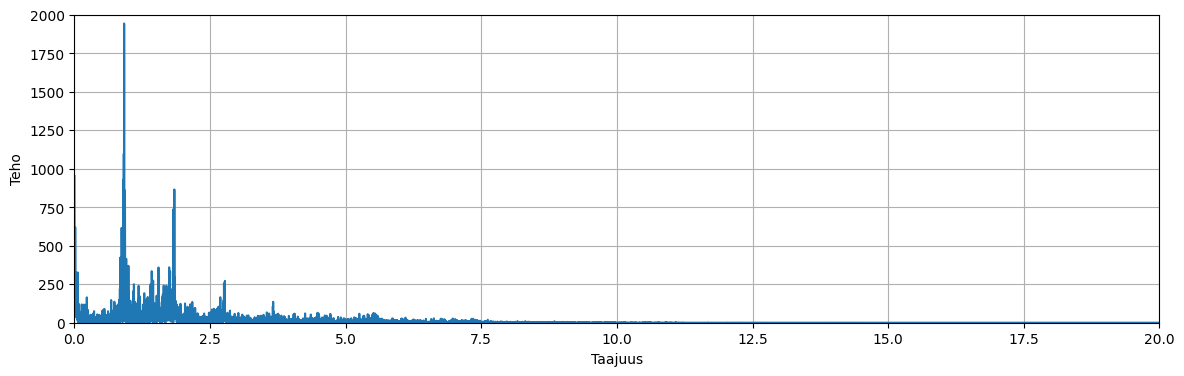

In [91]:
#ASKELMÄÄRÄ LASKETTUNA KIIHTYVYYSDATASTA FOURIER-ANALYYSIN PERUSTEELLA:
f = dfLinAcc['Linear Acceleration y (m/s^2)'] #Valittu signaali
t = dfLinAcc['Time (s)'] #Aika
N = len(dfLinAcc) #Havaintojen määrä
dt = np.max(t)/len(t) #Oletetaan sämpläystaajuus vakioksi

fourier = np.fft.fft(f,N) #Fourier-muunnos
psd = fourier*np.conj(fourier)/N #Tehospektri
freq = np.fft.fftfreq(N,dt) #Taajuudet
L = np.arange(1,int(N/2))#Rajataan pois nollataajuus ja negatiiviset taajuudet

plt.figure(figsize = (14,4))
plt.plot(freq[L], psd[L].real)
plt.ylabel('Teho')
plt.xlabel('Taajuus')
plt.grid()
plt.axis([0,20,0,2000])
plt.show()

In [9]:

print ('Kävelydatan tehokkain taajuus on ', freq[L][psd[L]==np.max(psd[L])][0], 'Hz.')
print ('Tämä vastaa askeleeseen kuluvaa aikaa ', 1/freq[L][psd[L]==np.max(psd[L])][0], 's.')
print('Tällöin askelmäärä on ' , freq[L][psd[L]==np.max(psd[L])][0]*np.max(t), 'askelta.')

Kävelydatan tehokkain taajuus on  0.9169538478234482 Hz.
Tämä vastaa askeleeseen kuluvaa aikaa  1.0905674286374134 s.
Tällöin askelmäärä on  433.0 askelta.


In [10]:
df = pd.read_csv("Location.csv")

df.head()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,0.000000,68.681404,27.661718,NaN,NaN,NaN,60.0,0.000000
1,1.978228,68.681325,27.661872,168.822049,1.361955,15.860000,5.1,63.599998
2,2.478228,68.681283,27.661912,145.222170,1.009370,7.100000,3.2,24.100000
3,2.978228,68.681298,27.661917,144.422151,0.917750,1.100000,2.9,21.100000
4,3.478228,68.681313,27.661905,141.522110,0.773628,356.549988,2.7,20.200001


In [12]:
#Haversinen kaava pisteiden välimatkojen laskemiseen
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points on the earth (specified in decimal degrees)
    """
    #Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    #haversine formula
    dlon = lon2 - lon1
    dlat = lat2 -lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 #Radius of earth in kilometers.
    return c * r 

In [67]:
#Lasketaan nopeus, matka, (vaikka ne olisivat jo valmiina datassa)

#Alustetaan tyhjät sarakkeet dataframeen
df['dist'] = np.zeros(len(df)) #Etäisyys pisteiden välillä
df['time_diff'] = np.zeros(len(df)) #Aika pisteiden välillä
df['average_velocity'] = np.zeros(len(df)) #Keskinopeus

for i in range(len(df)-1):
    #Tämä on kahden peräkkäisen pisteen välimatka
    df.loc[i, 'dist'] = haversine(df['Longitude (°)'][i], df['Latitude (°)'][i], df['Longitude (°)'][i+1], df['Latitude (°)'][i+1])*1000
    #Lisäksi lasketaan myös peräkkäisten pisteiden välinen aika
    df.loc[i, 'time_diff'] = df['Time (s)'][i]
    #Lasketaan keskinopeus
    df['velocity'] = df['dist']/df['time_diff']
    #Lasketaan kuljettu matka 
    df['tot_dist'] = np.cumsum(df['dist'])
    #Lasketaan keskinopeus koko matkalle gps-datasta
    df['average_velocity'] = np.cumsum(df['Velocity (m/s)'])/472
    

In [68]:
df.head()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m),dist,time_diff,velocity,tot_dist,average_velocity,AverageVelocity,step_dist
0,0.000000,68.681404,27.661718,NaN,NaN,NaN,60.0,0.000000,10.816105,0.000000,inf,10.816105,NaN,NaN,0.014898
1,1.978228,68.681325,27.661872,168.822049,1.361955,15.860000,5.1,63.599998,4.907546,1.978228,2.480778,15.723651,0.002885,0.002885,0.021658
2,2.478228,68.681283,27.661912,145.222170,1.009370,7.100000,3.2,24.100000,1.680127,2.478228,0.677955,17.403778,0.005024,0.005024,0.023972
3,2.978228,68.681298,27.661917,144.422151,0.917750,1.100000,2.9,21.100000,1.733359,2.978228,0.582010,19.137136,0.006968,0.006968,0.026360
4,3.478228,68.681313,27.661905,141.522110,0.773628,356.549988,2.7,20.200001,0.395035,3.478228,0.113574,19.532172,0.008607,0.008607,0.026904


In [58]:
#KESKINOPEUS(GPS-DATASTA)

print('Keskinopeus on',df['average_velocity'].loc[df.index[472]],'m/s.')
    

Keskinopeus on 0.8468467324796606 m/s.


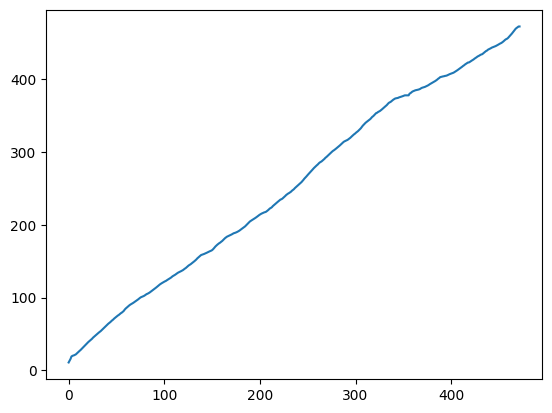

In [59]:
plt.plot(df['Time (s)'], df['tot_dist'])

In [60]:
#KULJETTU MATKA (GPS-DATASTA)
print('Kuljettu matka on ', df['tot_dist'].loc[df.index[472]], 'm.')


Kuljettu matka on  472.84346402590756 m.


In [61]:
#ASKELPITUUS LASKETUN ASKELMÄÄRÄN JA MATKAN PERUSTEELLA
df['step_dist'] = (df['tot_dist']/np.floor(jaksot / 2)) #Lisätään uusi sarake askelpituuden arvolle ja lasketaan sen arvo
print(df['step_dist'])


0      0.014898
1      0.021658
2      0.023972
3      0.026360
4      0.026904
         ...   
468    0.647164
469    0.648672
470    0.649948
471    0.651300
472    0.651300
Name: step_dist, Length: 473, dtype: float64


In [62]:
df.head()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m),dist,time_diff,velocity,tot_dist,average_velocity,AverageVelocity,step_dist
0,0.000000,68.681404,27.661718,NaN,NaN,NaN,60.0,0.000000,10.816105,0.000000,inf,10.816105,NaN,NaN,0.014898
1,1.978228,68.681325,27.661872,168.822049,1.361955,15.860000,5.1,63.599998,4.907546,1.978228,2.480778,15.723651,0.002885,0.002885,0.021658
2,2.478228,68.681283,27.661912,145.222170,1.009370,7.100000,3.2,24.100000,1.680127,2.478228,0.677955,17.403778,0.005024,0.005024,0.023972
3,2.978228,68.681298,27.661917,144.422151,0.917750,1.100000,2.9,21.100000,1.733359,2.978228,0.582010,19.137136,0.006968,0.006968,0.026360
4,3.478228,68.681313,27.661905,141.522110,0.773628,356.549988,2.7,20.200001,0.395035,3.478228,0.113574,19.532172,0.008607,0.008607,0.026904


In [63]:
print('Askelpituus on', df['step_dist'].loc[df.index[472]], 'm.')

Askelpituus on 0.6512995372257679 m.


In [64]:
#KARTTAKUVAN PIIRTÄMINEN
import folium

start_lat = df['Latitude (°)'].mean()
start_long = df['Longitude (°)'].mean()
my_map = folium.Map(location = [start_lat, start_long], zoom_start = 14)


folium.PolyLine(df[['Latitude (°)','Longitude (°)' ]], color = 'green', weight = 2.5, opacity = 1).add_to(my_map)


my_map.save('kartta.html')
my_map

In [82]:
#Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta:
print('Askelmäärä on', np.floor(jaksot / 2),'(suodatetusta kiihtyvyysdatasta laskettuna)' ) 
#ASKELMÄÄRÄ LASKETTUNA KIIHTYVYYSDATASTA FOURIER-ANALYYSIN PERUSTEELLA:
print('Askelmäärä on ' , freq[L][psd[L]==np.max(psd[L])][0]*np.max(t), 'askelta.(Fourier-analyysin perusteella)')
#KESKINOPEUS(GPS-DATASTA)
print('Keskinopeus on',df['average_velocity'].loc[df.index[472]],'m/s.(gps-datasta)')
#KULJETTU MATKA (GPS-DATASTA)
print('Kuljettu matka on ', df['tot_dist'].loc[df.index[472]], 'm.(gps-datasta)')
#ASKELPITUUS LASKETUN ASKELMÄÄRÄN JA MATKAN PERUSTEELLA
print('Askelpituus on', df['step_dist'].loc[df.index[472]], 'm. (lasketun askelmäärän(suodatettu data) ja matkan perusteella)')

Askelmäärä on 726.0 (suodatetusta kiihtyvyysdatasta laskettuna)
Askelmäärä on  433.0 askelta.(Fourier-analyysin perusteella)
Keskinopeus on 0.8468467324796606 m/s.(gps-datasta)
Kuljettu matka on  472.84346402590756 m.(gps-datasta)
Askelpituus on 0.6512995372257679 m. (lasketun askelmäärän(suodatettu data) ja matkan perusteella)


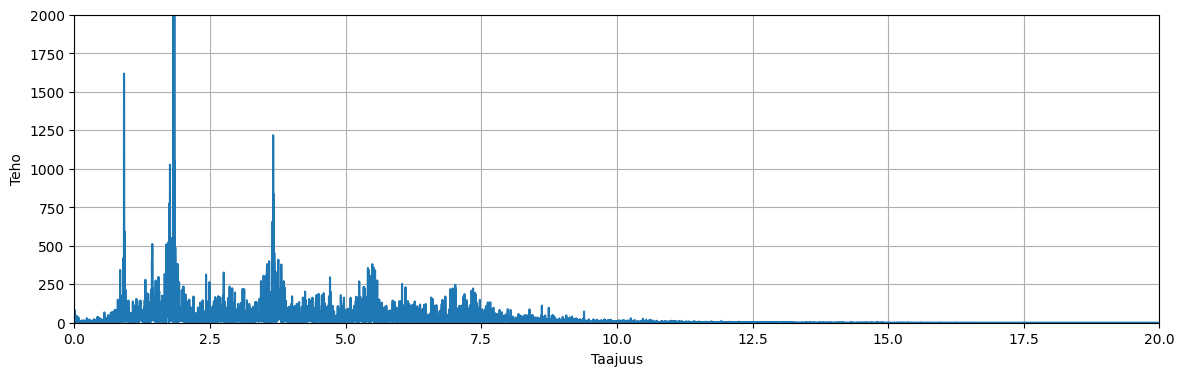

In [87]:
#ASKELMÄÄRÄ LASKETTUNA KIIHTYVYYSDATASTA FOURIER-ANALYYSIN PERUSTEELLA:
f = dfLinAcc['Linear Acceleration z (m/s^2)'] #Valittu signaali
t = dfLinAcc['Time (s)'] #Aika
N = len(dfLinAcc) #Havaintojen määrä
dt = np.max(t)/len(t) #Oletetaan sämpläystaajuus vakioksi

fourier = np.fft.fft(f,N) #Fourier-muunnos
psd = fourier*np.conj(fourier)/N #Tehospektri
freq = np.fft.fftfreq(N,dt) #Taajuudet
L = np.arange(1,int(N/2))#Rajataan pois nollataajuus ja negatiiviset taajuudet

plt.figure(figsize = (14,4))
plt.plot(freq[L], psd[L].real)
plt.ylabel('Teho')
plt.xlabel('Taajuus')
plt.grid()
plt.axis([0,20,0,2000])
plt.show()

In [88]:

print ('Kävelydatan tehokkain taajuus on ', freq[L][psd[L]==np.max(psd[L])][0], 'Hz.')
print ('Tämä vastaa askeleeseen kuluvaa aikaa ', 1/freq[L][psd[L]==np.max(psd[L])][0], 's.')
print('Tällöin askelmäärä on ' , freq[L][psd[L]==np.max(psd[L])][0]*np.max(t), 'askelta.')

Kävelydatan tehokkain taajuus on  1.8423784009385682 Hz.
Tämä vastaa askeleeseen kuluvaa aikaa  0.5427766627586207 s.
Tällöin askelmäärä on  870.0000000000001 askelta.


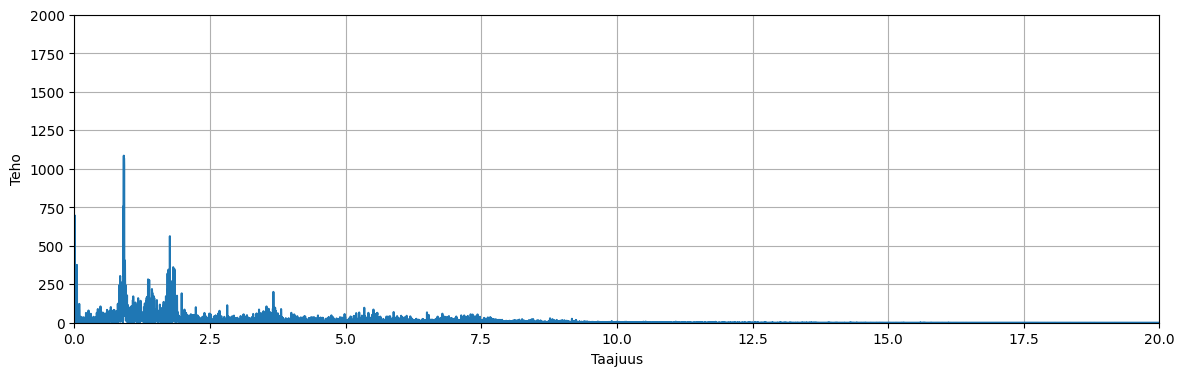

In [89]:
#ASKELMÄÄRÄ LASKETTUNA KIIHTYVYYSDATASTA FOURIER-ANALYYSIN PERUSTEELLA:
f = dfLinAcc['Linear Acceleration x (m/s^2)'] #Valittu signaali
t = dfLinAcc['Time (s)'] #Aika
N = len(dfLinAcc) #Havaintojen määrä
dt = np.max(t)/len(t) #Oletetaan sämpläystaajuus vakioksi

fourier = np.fft.fft(f,N) #Fourier-muunnos
psd = fourier*np.conj(fourier)/N #Tehospektri
freq = np.fft.fftfreq(N,dt) #Taajuudet
L = np.arange(1,int(N/2))#Rajataan pois nollataajuus ja negatiiviset taajuudet

plt.figure(figsize = (14,4))
plt.plot(freq[L], psd[L].real)
plt.ylabel('Teho')
plt.xlabel('Taajuus')
plt.grid()
plt.axis([0,20,0,2000])
plt.show()

In [90]:
print ('Kävelydatan tehokkain taajuus on ', freq[L][psd[L]==np.max(psd[L])][0], 'Hz.')
print ('Tämä vastaa askeleeseen kuluvaa aikaa ', 1/freq[L][psd[L]==np.max(psd[L])][0], 's.')
print('Tällöin askelmäärä on ' , freq[L][psd[L]==np.max(psd[L])][0]*np.max(t), 'askelta.')

Kävelydatan tehokkain taajuus on  0.9106008188546946 Hz.
Tämä vastaa askeleeseen kuluvaa aikaa  1.098176038604651 s.
Tällöin askelmäärä on  430.0 askelta.
